In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os 
from matplotlib.colors import ListedColormap
from random import random
from random import randrange
from random import shuffle

# Runs through the steps of the Program

In [2]:
numParticles = 1000
timeStep = 0.001
initiallyInfected = int(0.1 * numParticles)
infectionRadius = 1/numParticles
currentStep = 0
stepsToRecovery = 20

Let $\vec{X}$ be a $1 \times n$ vector containing the $x$ coördinates of the $n$ particles. Let each of these coördinates be initialised as draws from a uniform distribution. Similarly define $\vec{Y}$. Zip the two to create a $2 \times n$ vector of $(x, y)$ coordinates.

The vectors in the cell below are: 
- `positions`: The zipped array containing $x$ and $y$ coördinates for each of the particles
- `timeInfected`: The time period in which particles' state changed from 0 to 1 
- `seedInfections`: The particles that are infected in period 0
- `status`: A vector that encodes the status of each of the particles as 0, 1, and 2, which correspond to susceptible, infected, and recovered respectively. 

In [3]:
positions = np.array(list(zip(np.random.uniform(size=numParticles), 
                             np.random.uniform(size=numParticles))))

status = np.zeros(numParticles)
timeInfected = np.array([np.nan] * numParticles)

seedInfections = np.arange(numParticles)
np.random.shuffle(seedInfections)
seedInfections = seedInfections[:initiallyInfected]
status[seedInfections] = 1
timeInfected[seedInfections] = 0

print(positions)
positions.T

[[0.76113216 0.08843733]
 [0.00942756 0.22682145]
 [0.10238704 0.1444093 ]
 ...
 [0.97227859 0.57633198]
 [0.0110276  0.19695539]
 [0.72625366 0.41571627]]


array([[0.76113216, 0.00942756, 0.10238704, ..., 0.97227859, 0.0110276 ,
        0.72625366],
       [0.08843733, 0.22682145, 0.1444093 , ..., 0.57633198, 0.19695539,
        0.41571627]])

Generate the first plot

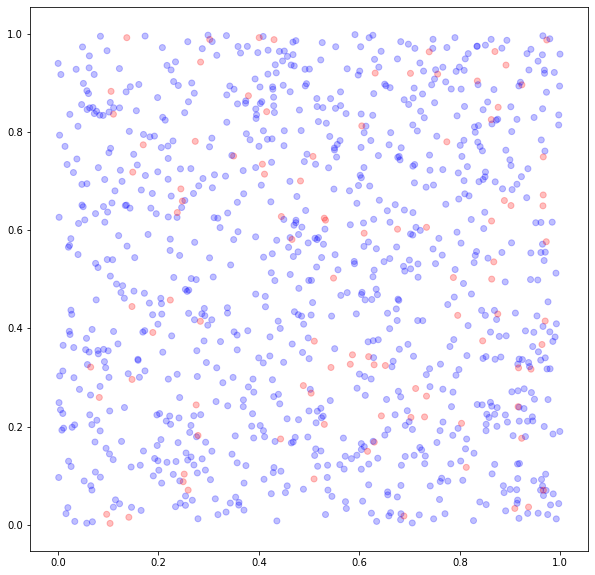

In [4]:
coordinates = positions.T
fig = plt.figure(figsize=(10, 10))
fig.add_axes(xlim=(-0.01, 1.01), ylim=(-0.01, 1.01))
cmap = ListedColormap(['blue', 'red'])
plt.scatter(coordinates[0], coordinates[1], c=status, cmap=cmap, alpha=0.25)

Generate velocities

In [5]:
velocities = np.random.multivariate_normal([0, 0], np.identity(2), 
                                           size=(numParticles))
print(positions)
newPositions = positions + velocities*timeStep
currentStep = currentStep + 1

[[0.76113216 0.08843733]
 [0.00942756 0.22682145]
 [0.10238704 0.1444093 ]
 ...
 [0.97227859 0.57633198]
 [0.0110276  0.19695539]
 [0.72625366 0.41571627]]


Ensure particles stay within the frame

In [6]:
coordinates = newPositions.T

coordinates[0][coordinates[0] < 0] = np.abs(coordinates[0][coordinates[0] < 0] + 1)
coordinates[0][coordinates[0] > 1] = coordinates[0][coordinates[0] > 1] - 1
coordinates[1][coordinates[1] < 0] = np.abs(coordinates[1][coordinates[1] < 0] + 1)
coordinates[1][coordinates[1] > 1] = coordinates[1][coordinates[1] > 1] - 1

newPositions = coordinates.T

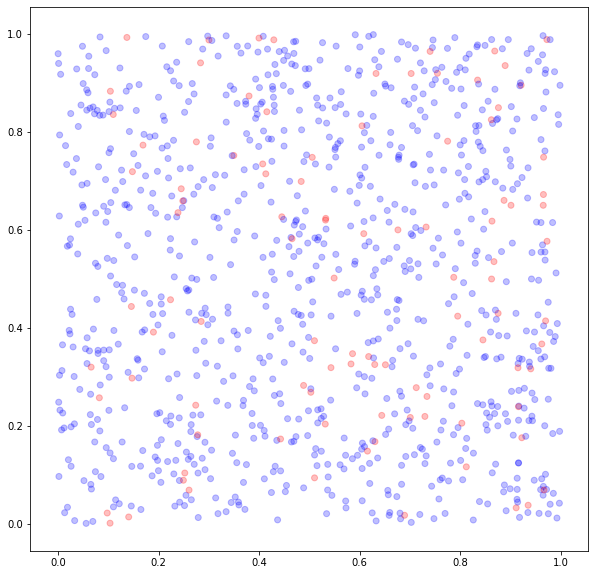

In [7]:
fig = plt.figure(figsize=(10, 10))
cmap = ListedColormap(['blue', 'red'])
plt.scatter(coordinates[0], coordinates[1], c=status, cmap=cmap, alpha=0.25)
fig.add_axes(xlim=(-0.01, 1.01), ylim=(-0.01, 1.01))

Calculate distances

In [8]:
np.sum(status)

100.0

In [9]:
%%time
xDistances = coordinates[0] - coordinates[0].reshape(numParticles, 1)
yDistances = coordinates[1] - coordinates[1].reshape(numParticles, 1)
euclideanDist = np.sqrt(xDistances**2 + yDistances**2)

checkInfected = euclideanDist * status

toCheck = np.argwhere((checkInfected > 0) & (checkInfected < 10*infectionRadius))

newInfections = set(toCheck.flatten()).difference(np.argwhere(status==1).flatten())
newInfections = list(newInfections)
status[newInfections] = 1
timeInfected[newInfections] = currentStep

CPU times: user 21 ms, sys: 12.6 ms, total: 33.6 ms
Wall time: 33 ms


In [10]:
np.sum(status)

130.0

In [11]:
collisions = np.argwhere((euclideanDist > 0) & (euclideanDist < 1/numParticles))

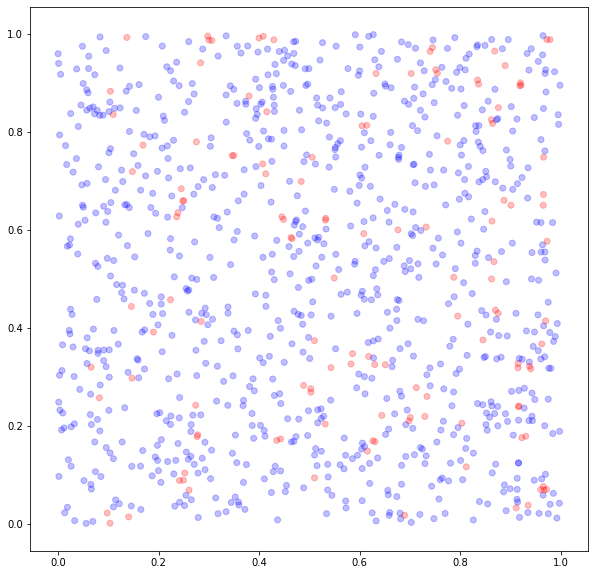

In [12]:
fig = plt.figure(figsize=(10, 10))
cmap = ListedColormap(['blue', 'red'])
plt.scatter(coordinates[0], coordinates[1], c=status, cmap=cmap, alpha=0.25)
fig.add_axes(xlim=(-0.01, 1.01), ylim=(-0.01, 1.01))

# Encapsulates everything above neatly into functions

In [13]:
def keepInFrame(coordinates, velocities):
  """
    Reverses the velocities of each of the particles that leave the frame
  """
  coordinates = coordinates.T
  velocities = velocities.T
  
  velocities[0][coordinates[0] < 0] = -velocities[0][coordinates[0] < 0]
  velocities[0][coordinates[0] > 1] = -velocities[0][coordinates[0] > 1]
  velocities[1][coordinates[1] < 0] = -velocities[1][coordinates[1] < 0]
  velocities[1][coordinates[1] > 1] = -velocities[1][coordinates[1] > 1]
  
  return coordinates.T, velocities.T

In [14]:
def getEuclideanDistances(coordinates):
  """
    Takes the coordinates as inputs and spits out the euclidean distances between each pair
  """
  coordinates = coordinates.T
  xDist = coordinates[0] - coordinates[0].reshape(numParticles, 1)
  yDist = coordinates[1] - coordinates[1].reshape(numParticles, 1)
  euclideanDist = np.sqrt(xDist**2 + yDist**2)
  ## changed upper triangular matrix to normal matrix so that all cases are considered
  return euclideanDist

In [118]:
def diceroll(status,mask_non_infected,mask_infected):
    if(status == 0 & mask_non_infected == 0 & mask_infected == 0):
        if(randrange(10)>3):
            return True
    if(status == 0 & mask_non_infected == 1  & mask_infected == 0):
        if(randrange(10)>5):
            return True
    if(status == 0 & mask_non_infected == 0 & mask_infected == 1):
        if(randrange(10)>6):
            return True
    if(status == 0 & mask_non_infected == 1 & mask_infected == 1):
        if(randrange(10)>7):
            return True
    if(status == 2 & mask_non_infected == 0 & mask_infected == 0):
        if(randrange(10)>5):
            return True
    if(status == 2 & mask_non_infected == 1 & mask_infected == 0):
        if(randrange(10)>6):
            return True
    if(status == 2 & mask_non_infected == 0 & mask_infected == 1):
        if(randrange(10)>7):
            return True
    if(status == 2 & mask_non_infected == 1 & mask_infected == 1):
        if(randrange(10)>8):
            return True

In [119]:
def testing(exposures,masks,status):
    new_infected = []
    for i in range(len(exposures)):
        if status[exposures[i][0]] == 1:
            if status[exposures[i][1]] == 2:
                if diceroll(2,masks[exposures[i][1]],masks[exposures[i][0]]):
                    new_infected.append(exposures[i][1])
            if status[exposures[i][1]] == 0:
                 if diceroll(0,masks[exposures[i][1]],masks[exposures[i][0]]):
                    new_infected.append(exposures[i][1]) 
        if status[exposures[i][0]] == 2:
             if diceroll(2,masks[exposures[i][0]],masks[exposures[i][1]]):
                    new_infected.append(exposures[i][0])
        if status[exposures[i][0]] == 0:
             if diceroll(0,masks[exposures[i][0]],masks[exposures[i][1]]):
                    new_infected.append(exposures[i][0])
    return new_infected

In [120]:
def generateScatter(coordinates, status, cmap,infected_number,susceptible_number,recovered_number,iteration):
  """
    Generates a scatter plot and Time series plot and saves it in a folder named frames
  """
  coordinates = coordinates.T
  fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
  axes[0].plot(coordinates[0][status==0], coordinates[1][status==0], 
              'o', alpha=0.25, label='Susceptible')
  axes[0].plot(coordinates[0][status==1], coordinates[1][status==1],
             'o', alpha=0.25, label='Infected')
  axes[0].plot(coordinates[0][status==2], coordinates[1][status==2],
             'o', alpha=0.25, label='Recovered')
  axes[0].set_ylim(-0.01, 1.01)
  axes[0].set_xlim(-0.01, 1.01)
  axes[0].legend(loc='upper left', bbox_to_anchor=(1, 0.5))
  
  X = iteration
  axes[1].set_ylim(0, 1000)
  axes[1].plot(X, susceptible_number,label= "Susceptible",marker='.')
  axes[1].plot(X, infected_number,label= "Infected",marker=".")
  axes[1].plot(X, recovered_number,label= "Recovered",marker='.')
  axes[1].legend(loc='upper left', bbox_to_anchor=(1, 0.5))
  axes[1].set_xlabel('Iterations')
  axes[1].set_ylabel('Population')
    
  ## x axis contians multiples of 1 values only.
  if(len(iteration) <= 10 ):
   axes[1].xaxis.set_major_locator(mticker.MultipleLocator(1))
  axes[1].yaxis.set_major_locator(mticker.MultipleLocator(100))
  
  #fig.tight_layout()
  ## better dpi gives quality, but slowes down the process
  ##fig.savefig(f"{os.getcwd()}/frames/frame{i:04}.png",dpi=300, bbox_inches='tight')
  plt.show()
  plt.close()

# Code cell that loops over the simulation for a certain number of time periods

Re-initialises the various vectors and runs the simulation for a thousand periods.

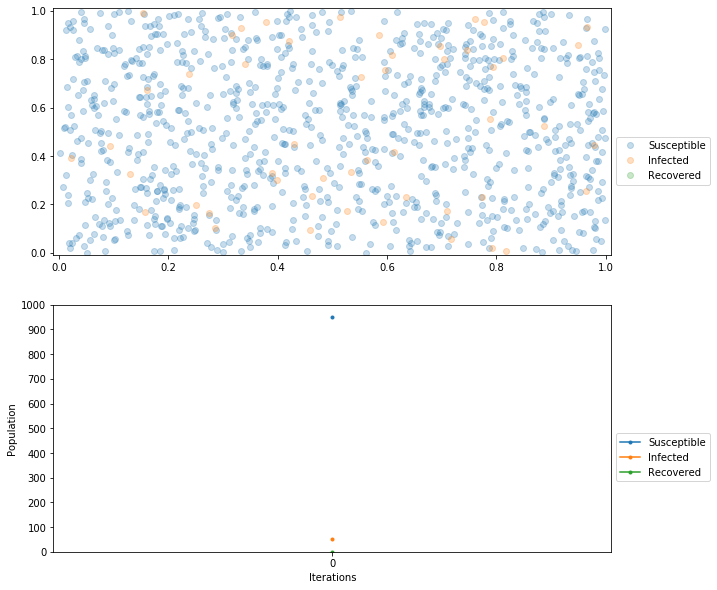

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in greater


array([], dtype=int64)

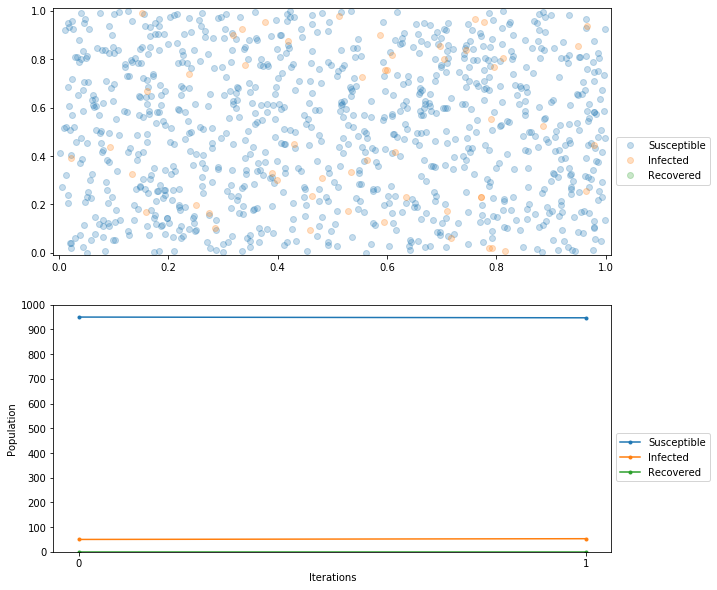

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in greater


array([], dtype=int64)

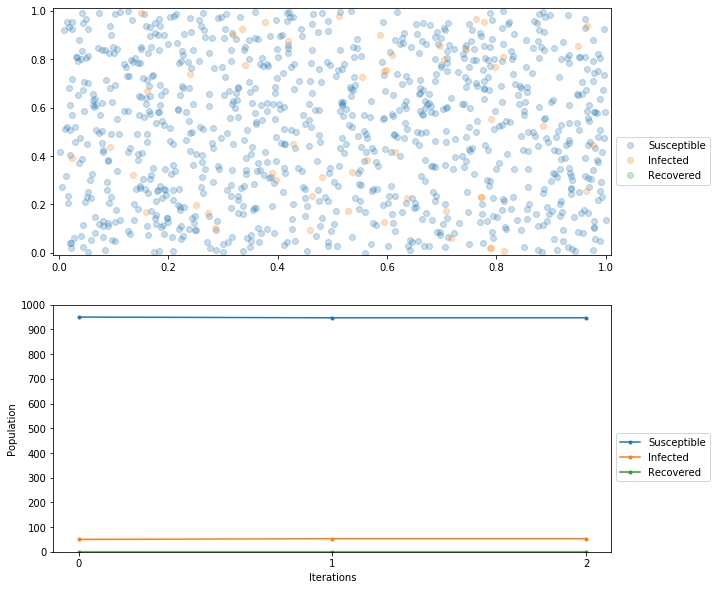

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in greater


array([], dtype=int64)

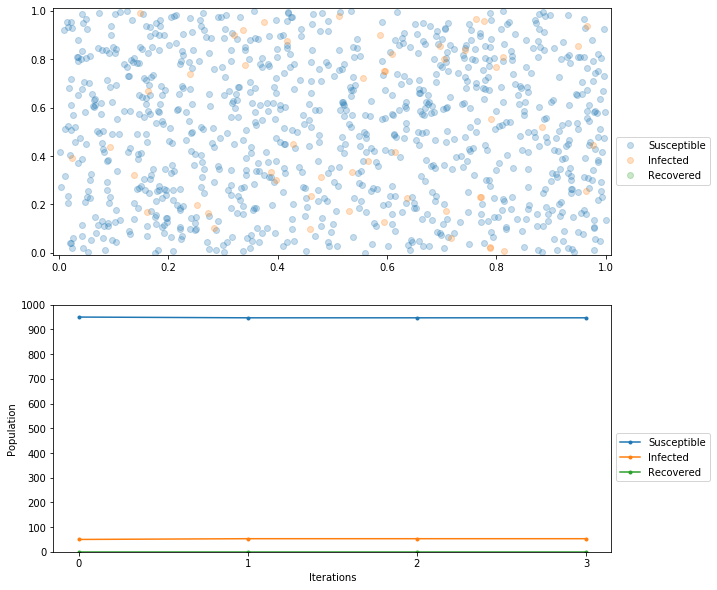

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in greater


array([], dtype=int64)

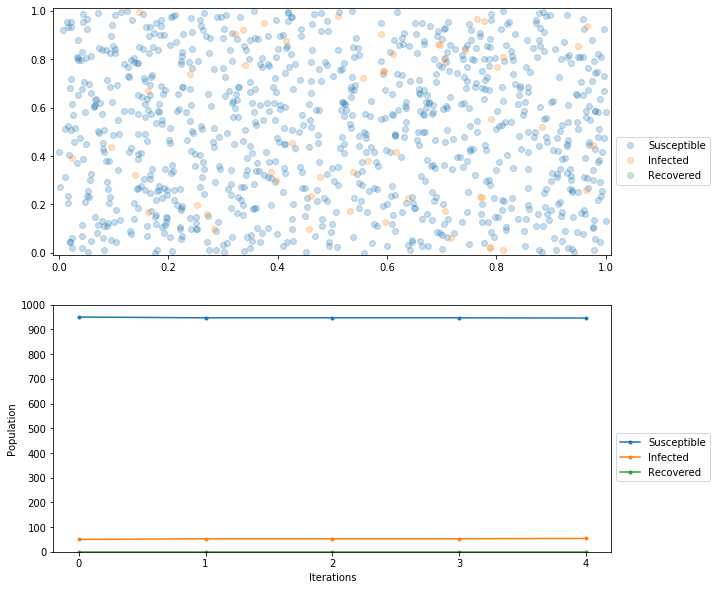

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in greater


array([], dtype=int64)

KeyboardInterrupt: 

In [123]:
i = 1
positions = np.array(list(zip(np.random.uniform(size=numParticles), 
                             np.random.uniform(size=numParticles))))
initiallyInfected = int(0.05 * numParticles)
status = np.zeros(numParticles)
timeInfected = np.array([np.nan] * numParticles)
seedInfections = np.arange(numParticles)
np.random.shuffle(seedInfections)
seedInfections = seedInfections[:initiallyInfected]
status[seedInfections] = 1
timeInfected[seedInfections] = 0
velocities = np.random.multivariate_normal([0, 0], np.identity(2),size=numParticles)
infected_number = [0.05 * numParticles]
susceptible_number = [numParticles-0.05 * numParticles]
recovered_number = [0]
iteration = [0]
generateScatter(positions, status, cmap,infected_number,susceptible_number,recovered_number,iteration)
print(f"Iteration: 0; Infected: {len(status[status==1])};\
  Susceptible: {len(status[status==0])}; Recovered: {len(status[status==2])}         ", 
        end="\r")


intial_masks = 0.1 * numParticles
masks = [1]*int(intial_masks) + [0]*int(numParticles-intial_masks)
shuffle(masks)


while i < 1000:
  # Draw acceleration vectors from a bivariate normal distribution
  acceleration = np.random.multivariate_normal([0, 0], 100*np.identity(2), 
                                            size = numParticles)
  
  # Update velocities
  velocities = velocities + acceleration * timeStep
  
  # Use velocities to update positions. Then make sure that the particles stay in the frame
  newPositions = positions + velocities * timeStep
  newPositions, velocities = keepInFrame(newPositions, velocities)
  
  # Calculate distance of the particles from each other
  euclideanDist = getEuclideanDistances(newPositions)
  
  # Figure out which particles are currently infected
  currentlyInfected = np.zeros_like(status)
  currentlyInfected[status==1] = 1
  
  # This makes the matrix sparser by setting all the columns corresponding to not-infected particles to 0. 
  # This should (?) result in a performance boost, but I'm not entirely sure if it does.
  exposureMatrix = np.multiply(euclideanDist, currentlyInfected)
    

  # Gets the pairs of particles that have been exposed to the infection. 
  # Playing around with the scaling factor of the infection radius will have an impact on R0
  exposures = np.argwhere((exposureMatrix > 0) & (exposureMatrix < 5*infectionRadius))

  # Not sure which ones of the exposures are already infected, so taking the set difference of the exposed 
  # particles and the ones that are currently infected to ensure we're looking at fresh infections.
  newInfections = testing(exposures,masks,status)
  # Update status and period of infection for each of the newly infected particles
  status[newInfections] = 1
  timeInfected[newInfections] = i + 1
  
  # So right now the simulation assumes it takes 125 periods to recover from the infection. Altering 
  # this will change the results. The cmap is an artefact from an older version of the simulation so 
  # ignore it for the time being. We can clean it up later.
#   if i > 125:
#     cmap = ListedColormap(['blue', 'red', 'green'])
#   else:
#     cmap = ListedColormap(['blue', 'red'])
  
  
  # This is the latest version of the code. If a particle is infected and has been for over 125 periods, 
  # then set its status to recovered, i.e. 2. We can also improve upon the simulation by setting a mortality 
  # rate over here. After some periods, the particle has some probability of leaving the simulation. But 
  # that's for later.
  recovered = np.argwhere((status==1) & (i - timeInfected > 125)).flatten()
  display(recovered)
  status[recovered] = 2
    
  ##Adding 'number' of patients to the respective list
  infected_number.append(len(status[status==1]))
  susceptible_number.append(len(status[status==0]))
  recovered_number.append(len(status[status==2]))
  iteration.append(i)

  
  # Generate the scatter plot and save it to the disk
  generateScatter(newPositions, status, cmap,infected_number,susceptible_number,recovered_number,iteration)
  
  
  # Update positions so they're adjusted appropriately in the next run.
  positions = newPositions
  
  # Just some printing to figure out the stage of the simulation. Can use the len(status) bit to generate the 
  # epidemiology curve plot.
  print(f"Iteration: {i}; Infected: {len(status[status==1])};\
  Susceptible: {len(status[status==0])}; Recovered: {len(status[status==2])}         ", 
        end="\r")
    
  # Increment time
  i = i + 1

# What needs to be done

1. Need to come up with some calibrated values to generate the distributions of particle velocities and accelerations that are applied to them. 
    - The `stepsUntil` function may be of some help on this front. 
2. Need to generate a plot with a bar that is coloured in proportion to the number of individuals that are susceptible, infected, and recovered. Already calculating the number of susceptible particles by calling `len(status[status==0])`, and similarly for those that are infected and have recovered. Just need to generate the plots in every period.  
    1. Need to output the plot alongside the current scatter plot.  
    2. Need to figure out why the axes of the scatter plot 'jiggle'  
    3. I think there's a bug that causes the number of recovered people to go reduce between one period and the next. Can't figure out why that's happening.  
3. Need to create a function that takes the number of people who have been exposed in each period---currently contained in the vector `exposures`---and change their status probabilistically. 
    1. Start with the `exposures` vector. 
    2. Generate a vector of random numbers that is of the same size as `exposures` where each entry is picked from a uniform distribution over the unit interval.
    3. Come up with some threshold, say 60%, and update the status accordingly. So if entry 2 is exposed and the random value corresponding to 2 is less than the threshold, then don't change the status. If the value exceeds the threshold, then update the status of 2 to 1. 
4. Figure out the scenarios (we can work on this once the above points have been dealt with). The scenarios Kush has okay-ed up until now are: 
    1. Social distancing: For this we just create a repulsive force between the particles, which we've done in the other notebook. 
    2. Some fraction of the population wearing masks: If you're exposed to a particle that is infected and wears a mask, then the threshold should be higher.

In [ ]:
def stepsUntil(initialState, collisionThreshold, sigma=1):
  """
    A function that calculates the number of timeStep increments it takes 
    for the collisionThreshold to be reached.
    
    initialState: the initial positions of the particles
  """
  collisions = 0
  steps = 0
  positions = initialState
  previousExposures = set()
  while collisions < collisionThreshold:
    velocities = np.random.multivariate_normal([0, 0], sigma**2 * np.identity(2),
                                              size = numParticles)
    newPositions = positions + velocities * timeStep
    newPositions = keepInFrame(newPositions)
    euclideanDist = getEuclideanDistances(newPositions)
    exposures = np.argwhere((euclideanDist > 0) & (euclideanDist < 2*infectionRadius))
    exposures = set((f[0], f[1]) for f in exposures)
    newExposures = exposures.difference(previousExposures)
    collisions = collisions + len(newExposures)
#     print(f"Total exposures: {len(exposures)}; new exposures: {len(newExposures)}")
    steps = steps + 1
    print(f"Step: {steps}, Collisions: {collisions:.0f}", end='\r')
    positions = newPositions
    previousExposures = list(exposures)
  print('                                           ', end='\r')
  return steps